## **Data Science Club - Introduction to Deep Learning using MNIST Dataset**


In [ ]:
# Importing the relevant packages
import io
import itertools

import numpy as np
import sklearn.metrics

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

## Downloading and preprocessing the data

In [ ]:
# Defining some constants/hyperparameters
BUFFER_SIZE = 70_000 # for reshuffling
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [ ]:
# Downloading the MNIST dataset
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Extract the train and test set
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

In [ ]:
# Note that black and white images are in [0,255] with 255 being white and 0 being black. So we need to rescale in range of [0,1]
# Creating a function to scale our data
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.

    return image, label

In [ ]:
# Scaling the data
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [ ]:
# Defining the size of validation set (we use 20% of trainset as validation)
num_validation_samples = 0.2 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [ ]:
# Defining size of test set
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [ ]:
# Reshuffling the dataset (I want to reshuffle the data in order to main consistency)
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [ ]:
# Splitting the dataset into training + validation
train_data = train_and_validation_data.skip(num_validation_samples)
validation_data = train_and_validation_data.take(num_validation_samples)

In [ ]:
# Batching the data 
# Will do if I get time (but batching is one of the hyperparameters I can tune)
train_data = train_data.batch(BATCH_SIZE)
# The above line is done because we will be back propagating too on train if I get time

validation_data = validation_data.batch(num_validation_samples)
test_data = test_data.batch(num_test_samples)

## Building the model and training it

In [ ]:
# Now that we have preprocessed the dataset, we can define our CNN and train it

In [ ]:
# Outlining the model/architecture of our CNN

# Since we only given 3 layers to train, I will use the conv2d layer, max pool
# layer and the flatten layer. The dense layer will be only use to make 10 
# predictions

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])

In [ ]:
# A brief summary of the model and parameters
model.summary(line_length = 75)

Model: "sequential"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d (Conv2D)                 (None, 24, 24, 50)            1300        
                                                                           
 max_pooling2d (MaxPooling2D)    (None, 12, 12, 50)            0           
                                                                           
 flatten (Flatten)               (None, 7200)                  0           
                                                                           
 dense (Dense)                   (None, 10)                    72010       
                                                                           
Total params: 73,310
Trainable params: 73,310
Non-trainable params: 0
___________________________________________________________________________


In [ ]:
# Defining the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
# Compiling the model with Adam optimizer and the cathegorical crossentropy as a loss function
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

In [ ]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)
    
    buf.seek(0)
    
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [ ]:
# Defining early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

In [ ]:
# Train the network
mfit = model.fit(
    train_data, 
    epochs = NUM_EPOCHS, 
    callbacks = [early_stopping], 
    validation_data = validation_data,
    verbose = 2
)

# We can see after epoch 7, the model stopped running. It is because after 
# epoch 7, the model was overfitting (and to prevent we implemented early stopping)

Epoch 1/20
375/375 - 30s - loss: 1.3019 - accuracy: 0.9361 - val_loss: 1.4719 - val_accuracy: 0.9523 - 30s/epoch - 80ms/step
Epoch 2/20
375/375 - 45s - loss: 1.4336 - accuracy: 0.9273 - val_loss: 1.4289 - val_accuracy: 0.9450 - 45s/epoch - 119ms/step
Epoch 3/20
375/375 - 30s - loss: 1.2817 - accuracy: 0.9308 - val_loss: 1.2036 - val_accuracy: 0.9256 - 30s/epoch - 81ms/step
Epoch 4/20
375/375 - 31s - loss: 1.1535 - accuracy: 0.9155 - val_loss: 1.1916 - val_accuracy: 0.9090 - 31s/epoch - 82ms/step
Epoch 5/20
375/375 - 30s - loss: 1.0931 - accuracy: 0.9121 - val_loss: 1.0578 - val_accuracy: 0.9097 - 30s/epoch - 81ms/step
Epoch 6/20
375/375 - 30s - loss: 1.4228 - accuracy: 0.8831 - val_loss: 1.4178 - val_accuracy: 0.8971 - 30s/epoch - 81ms/step
Epoch 7/20
375/375 - 31s - loss: 1.5224 - accuracy: 0.9062 - val_loss: 1.6034 - val_accuracy: 0.9125 - 31s/epoch - 82ms/step


## Question 2 Solution: Plot of classification accuracy and losses (validation and training set) during training.

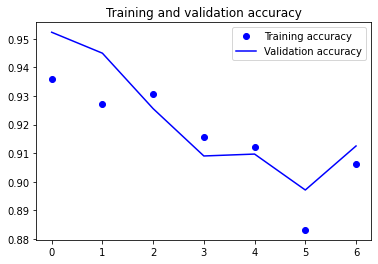

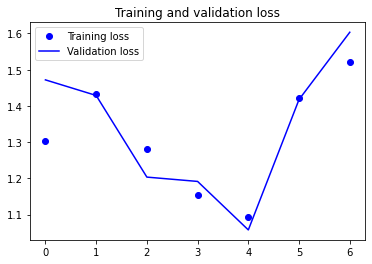

In [ ]:
accuracy = mfit.history['accuracy']
val_accuracy = mfit.history['val_accuracy']
loss = mfit.history['loss']
val_loss = mfit.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Q2: Confusion matrix for validation set

In [ ]:
# Extracting the numpy arrays from the validation data for the calculation of the Confusion Matrix
for images, labels in validation_data:
    images_val = images.numpy()
    labels_val = labels.numpy()

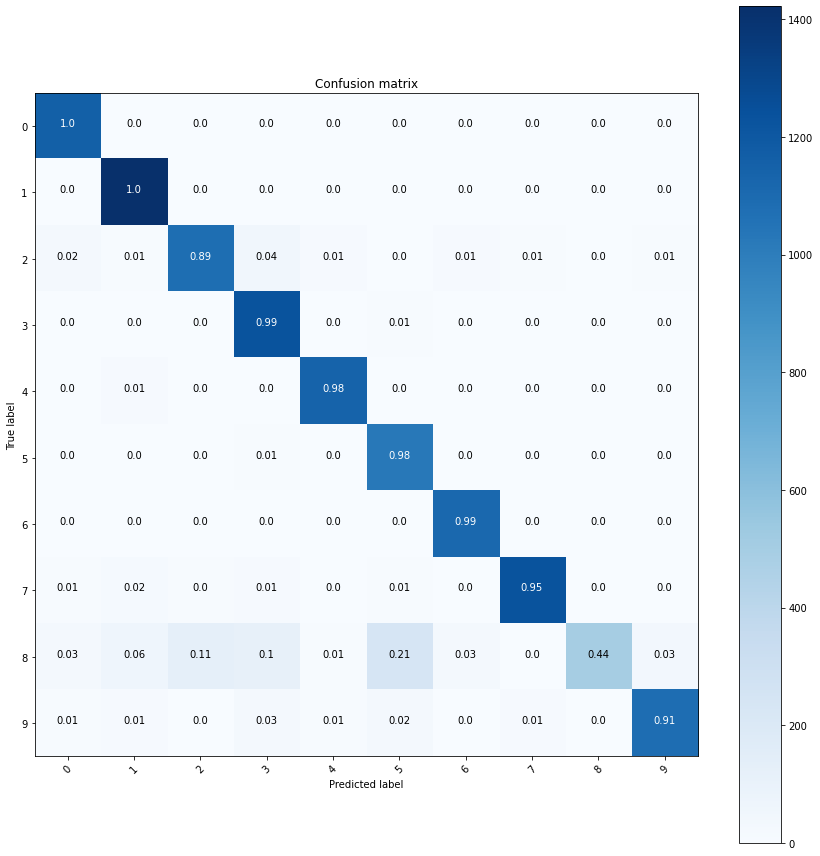

In [ ]:
from matplotlib import figure

valid_pred_raw = model.predict(images_val)
valid_pred = np.argmax(valid_pred_raw, axis=1)

# Calculate the confusion matrix.
cm = sklearn.metrics.confusion_matrix(labels_val, valid_pred)

# Log the confusion matrix as an image summary.
figure = plot_confusion_matrix(cm, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
cm_image = plot_to_image(figure)
figure

## Q2: Confusion matrix for train set

In [ ]:
for images, labels in train_data:
    images_train = images.numpy()
    labels_train = labels.numpy()

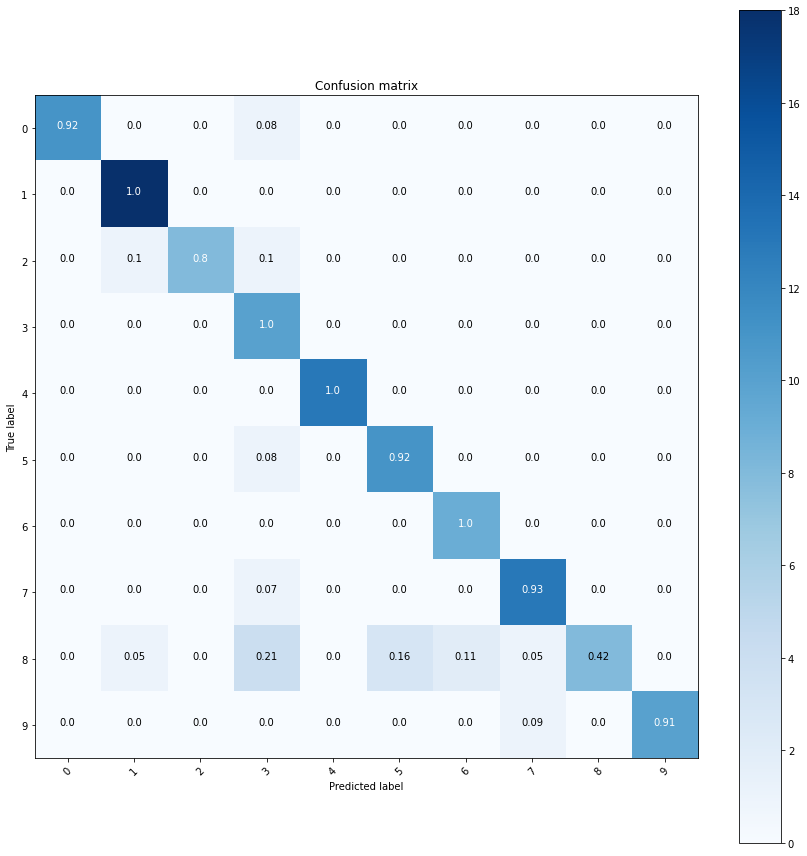

In [ ]:
from matplotlib import figure

train_pred_raw = model.predict(images_train)
train_pred = np.argmax(train_pred_raw, axis=1)

# Calculate the confusion matrix.
cm = sklearn.metrics.confusion_matrix(labels_train, train_pred)

# Log the confusion matrix as an image summary.
figure = plot_confusion_matrix(cm, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
cm_image = plot_to_image(figure)
figure

## Q3: Classification metrics (Precision, Recall, f1-scores) for test sets.

In [ ]:
from sklearn.metrics import classification_report

for images, labels in test_data:
    images_test = images.numpy()
    labels_test = labels.numpy()

predicted_classes = model.predict(images_test)
predicted_classes = np.argmax(predicted_classes, axis=1)

print(classification_report(labels_test, predicted_classes))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       980
           1       0.92      1.00      0.96      1135
           2       0.88      0.90      0.89      1032
           3       0.82      0.99      0.89      1010
           4       0.96      0.98      0.97       982
           5       0.79      0.97      0.87       892
           6       0.96      0.97      0.97       958
           7       0.97      0.94      0.95      1028
           8       1.00      0.42      0.59       974
           9       0.95      0.89      0.92      1009

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.90     10000
weighted avg       0.92      0.91      0.90     10000



## Q3: Classification metrics (Precision, Recall, f1-scores) for train sets.

In [ ]:
for images, labels in train_data:
    images_train = images.numpy()
    labels_train = labels.numpy()

train_pred_raw = model.predict(images_train)
train_pred = np.argmax(train_pred_raw, axis=1)

print(classification_report(labels_test, predicted_classes))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       980
           1       0.92      1.00      0.96      1135
           2       0.88      0.90      0.89      1032
           3       0.82      0.99      0.89      1010
           4       0.96      0.98      0.97       982
           5       0.79      0.97      0.87       892
           6       0.96      0.97      0.97       958
           7       0.97      0.94      0.95      1028
           8       1.00      0.42      0.59       974
           9       0.95      0.89      0.92      1009

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.90     10000
weighted avg       0.92      0.91      0.90     10000



## Question 5: Testing our model

In [ ]:
# Testing our model
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 2s 2s/step - loss: 0.0425 - accuracy: 0.9884


In [ ]:
# Printing the test results
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.0425. Test accuracy: 98.84%
